# **Autoencoders in Keras using Fashion_MNIST on Google Colab**

Original code from this blog using MNIST:
https://blog.keras.io/building-autoencoders-in-keras.html

In [0]:
### USE THIS TO KILL THE VIRTUAL MACHINE BEFORE CLOSING THIS COLAB NOTEBOOK:

!kill -9 -1

In [0]:
## Step 1: Mount Google Drive:

from google.colab import drive
drive.mount('/content/drive')

In [0]:
## Step 2: change directory to where your notebooks are:

import os
cwd = os.getcwd()
os.chdir("drive/My Drive/Colab Notebooks")
print(cwd)
!ls -ltr

In [9]:
# Import Numpy, TensorFlow, Keras and vectorized MNIST data
import numpy as np
from numpy import array
import tensorflow as tf
import keras
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# test BatchNormalization
from keras.layers.normalization import BatchNormalization

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [10]:
# Test to see if we have access to GPU

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### 1. Lets Start with simple Feed-Forward NN as encoder/decoder

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
# Now let's train our autoencoder to reconstruct MNIST digits.
# First, we'll configure our model to use a per-pixel binary crossentropy loss, 
# and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [17]:
# We will normalize all values between 0 and 1 and we will flatten the 28x28 
# images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [21]:
autoencoder.fit(x_train, x_train, 
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 1s 25us/step - loss: 0.3238 - val_loss: 0.3242
Epoch 2/30
60000/60000 [==============================] - 2s 25us/step - loss: 0.3210 - val_loss: 0.3216
Epoch 3/30
60000/60000 [==============================] - 2s 25us/step - loss: 0.3185 - val_loss: 0.3193
Epoch 4/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3164 - val_loss: 0.3173
Epoch 5/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3145 - val_loss: 0.3156
Epoch 6/30
60000/60000 [==============================] - 2s 25us/step - loss: 0.3129 - val_loss: 0.3141
Epoch 7/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3114 - val_loss: 0.3127
Epoch 8/30
60000/60000 [==============================] - 2s 25us/step - loss: 0.3101 - val_loss: 0.3115
Epoch 9/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3090 - val_loss: 0.3104
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

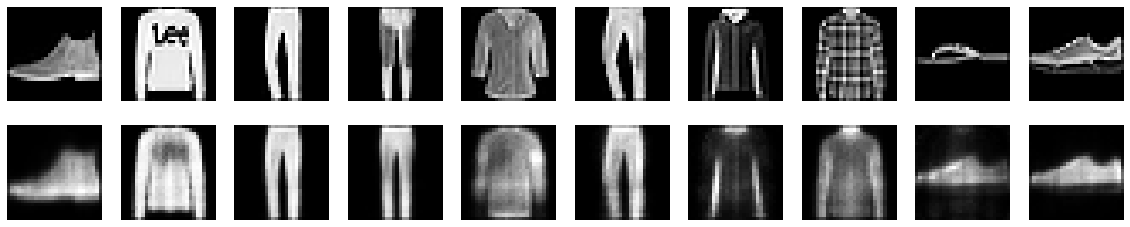

In [23]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


### Adding a sparsity constraint on the encoded representations. Limit the number of neurons firing by regularizing the activity:

In [0]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [0]:
# Now let's train our autoencoder to reconstruct MNIST digits.
# First, we'll configure our model to use a per-pixel binary crossentropy loss, 
# and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [27]:
autoencoder.fit(x_train, x_train, 
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 29us/step - loss: 0.6839 - val_loss: 0.6704
Epoch 2/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.6601 - val_loss: 0.6504
Epoch 3/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.6415 - val_loss: 0.6331
Epoch 4/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.6254 - val_loss: 0.6182
Epoch 5/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.6114 - val_loss: 0.6053
Epoch 6/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.5993 - val_loss: 0.5941
Epoch 7/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.5888 - val_loss: 0.5843
Epoch 8/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.5796 - val_loss: 0.5757
Epoch 9/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.5715 - val_loss: 0.5682
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

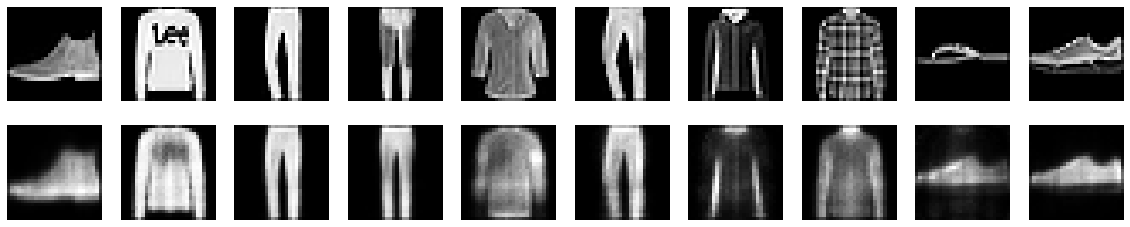

In [29]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Deep autoencoders; many layer fully-connected NN

In [0]:
# Lets increase the number of hidden layers:

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [32]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 3s 46us/step - loss: 0.3193 - val_loss: 0.3207
Epoch 2/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3181 - val_loss: 0.3175
Epoch 3/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3165 - val_loss: 0.3190
Epoch 4/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3154 - val_loss: 0.3174
Epoch 5/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3143 - val_loss: 0.3138
Epoch 6/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3130 - val_loss: 0.3185
Epoch 7/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3122 - val_loss: 0.3122
Epoch 8/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3111 - val_loss: 0.3162
Epoch 9/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3103 - val_loss: 0.3118
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

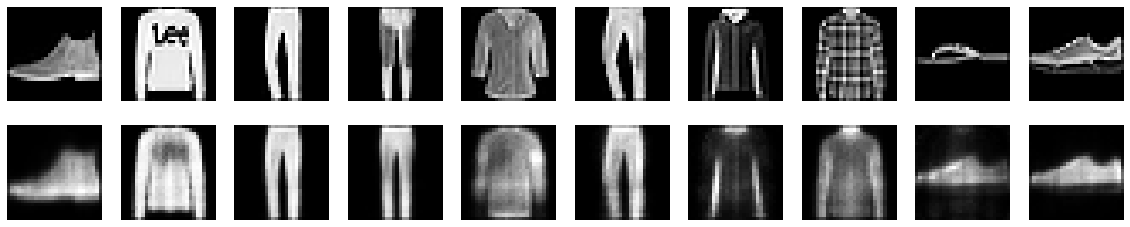

In [34]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Autoencoders

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [40]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 122us/step - loss: 0.2937 - val_loss: 0.2939
Epoch 2/30
60000/60000 [==============================] - 7s 122us/step - loss: 0.2928 - val_loss: 0.2980
Epoch 3/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.2920 - val_loss: 0.2928
Epoch 4/30
60000/60000 [==============================] - 7s 122us/step - loss: 0.2915 - val_loss: 0.2908
Epoch 5/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.2909 - val_loss: 0.2927
Epoch 6/30
60000/60000 [==============================] - 7s 120us/step - loss: 0.2906 - val_loss: 0.2916
Epoch 7/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.2903 - val_loss: 0.2930
Epoch 8/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.2896 - val_loss: 0.2914
Epoch 9/30
60000/60000 [==============================] - 7s 123us/step - loss: 0.2892 - val_loss: 0.2

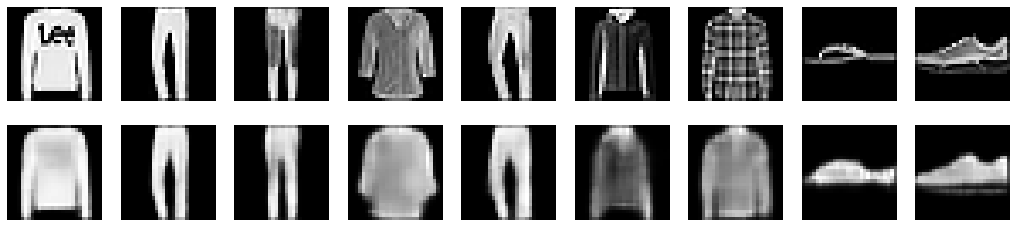

In [41]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

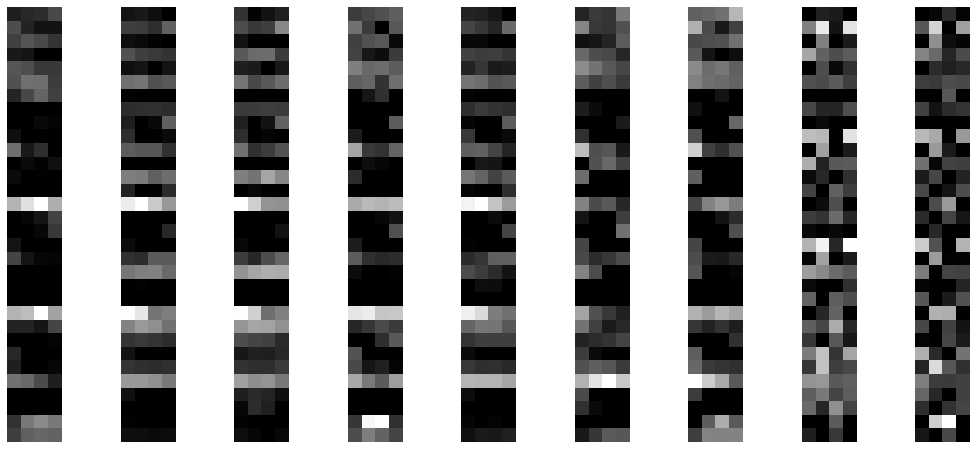

In [42]:
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **Application to image denoising:**

In [0]:
# Synthetic noise added to the images

from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

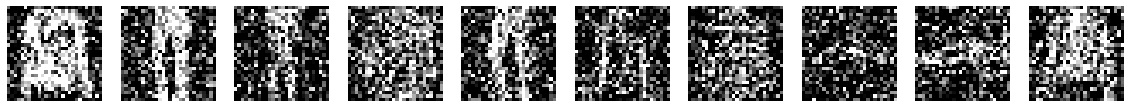

In [46]:
# Plot the noisy images:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [48]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 145us/step - loss: 0.3606 - val_loss: 0.3258
Epoch 2/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.3145 - val_loss: 0.3128
Epoch 3/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.3079 - val_loss: 0.3097
Epoch 4/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.3049 - val_loss: 0.3036
Epoch 5/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.3030 - val_loss: 0.3024
Epoch 6/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.3015 - val_loss: 0.3040
Epoch 7/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.3002 - val_loss: 0.3014
Epoch 8/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.2994 - val_loss: 0.3001
Epoch 9/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.2985 - val_loss: 0.3